# Analysis of the synthetic TODs produced with the GAN generation
- Generation of synthetic TODs (with best GAN model) compared with the MC simulated
- Correlation matrix between bolometers
- Noise equivalent power and Pair-subtracted NEP

In [33]:
import numpy as np

import matplotlib.pyplot as plt

import time
import random

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import seaborn as sns

# from ipynb.fs.full.complete_generated_TOD import GAN1

## Function import from complete_generated_TOD
- GAN_1
- Normalizition legacy

In [34]:
# GAN class wrapping generator-discriminator couple
class GAN_1(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight=1, extra_discr=1, val_data=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.synth_weight = synth_weight
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_val_loss_tracker = Mean(name="discr_loss_val")

        self.gen_acc_tracker = BinaryAccuracy(name="gen_acc", threshold=0.5)
        self.discr_acc_tracker = BinaryAccuracy(name="discr_acc", threshold=0.5)
        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_loss_tracker,
                self.gen_loss_val_tracker, self.discr_val_loss_tracker,
                self.gen_acc_tracker, self.discr_acc_tracker]
    
    @tf.function    
    def train_step(self, real_data):
        
        val_size = self.val_data.shape[0]
        
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
        
        # Use the pre-trained discriminator
        if self.extra_discr == 0:

            with GradientTape() as disc_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=False)
                fake_preds = self.discriminator(fake_data, training=False)

                discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

        # Train the discriminator
        else:
            
            for i in range(self.extra_discr):

                with GradientTape() as disc_tape:

                    fake_data = self.generator(inputnoise, training=False)
                    real_preds = self.discriminator(real_data, training=True)
                    fake_preds = self.discriminator(fake_data, training=True)

                    discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

                discr_grad = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)      
                self.discr_optimizer.apply_gradients(zip(discr_grad, self.discriminator.trainable_variables))

        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_tot_real_TODs = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_loss_val = self.discr_loss(real_preds_val, synth_preds_val, self.synth_weight)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_loss':
                m.update_state(discr_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_loss_val':
                m.update_state(discr_loss_val)
                
            if m.name == 'gen_acc':
                m.update_state(np.ones(val_size), synth_preds_val)
            if m.name == 'discr_acc':
                m.update_state(tf.concat([np.ones(val_size), np.zeros(val_size)], 0), tf.concat([real_preds_val, synth_preds_val], 0))
                
        return {m.name: m.result() for m in self.metrics}

# Normalization and absolute value of the synhtetic TOD

def normalize_synth(inputs):

    mins = tf.repeat(tf.math.reduce_min(inputs, axis=1), inputs.shape[1], axis=1)
    mins = tf.reshape(mins, tf.shape(inputs))
    maxs = tf.repeat(tf.math.reduce_max(inputs, axis=1), inputs.shape[1], axis=1)
    maxs = tf.reshape(maxs, tf.shape(inputs))
    
    return (inputs - mins)/(maxs-mins)

def abs_synth(inputs):
    
    return tf.math.abs(inputs)


# Normalization of the TODs and split in training and validation samples

def normalize(sample):

    mins = np.repeat(np.min(sample, axis=1), sample.shape[1], axis=1)
    mins = mins.reshape(sample.shape)
    maxs = np.repeat(np.max(sample, axis=1), sample.shape[1], axis=1)
    maxs = maxs.reshape(sample.shape)

    sample = (sample - mins)/(maxs-mins)
    
    return sample, mins, maxs

def denormalize(sample, mins, maxs):

    min_ = np.mean(mins)
    max_ = np.mean(maxs)
    sample = min_ + (max_-min_)*(sample)
  
    return sample

## MC simulation data and GAN model load
The data used are the Samantha Stever datasemple generated for the LFT detector. Both the Training and validation data are loaded to mantain the data sample structure as used in the complete_generated_TOD.ipynb code.

All the MC TODs sample is used for the analysis, containing both training and validation samples.
Then a sample of synthetic TODs of the same size of the MC one is generated by the GAN model loaded from trained NN in models directory.

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 265)               26765     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 265)               0         
                                                                 
 reshape_8 (Reshape)         (None, 265, 1)            0         
                                                                 
 conv1d_transpose_12 (Conv1  (None, 265, 8)            88        
 DTranspose)                                                     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 265, 8)            0         
                                                                 
 batch_normalization_17 (Ba  (None, 265, 8)            32        
 tchNormalization)                                       

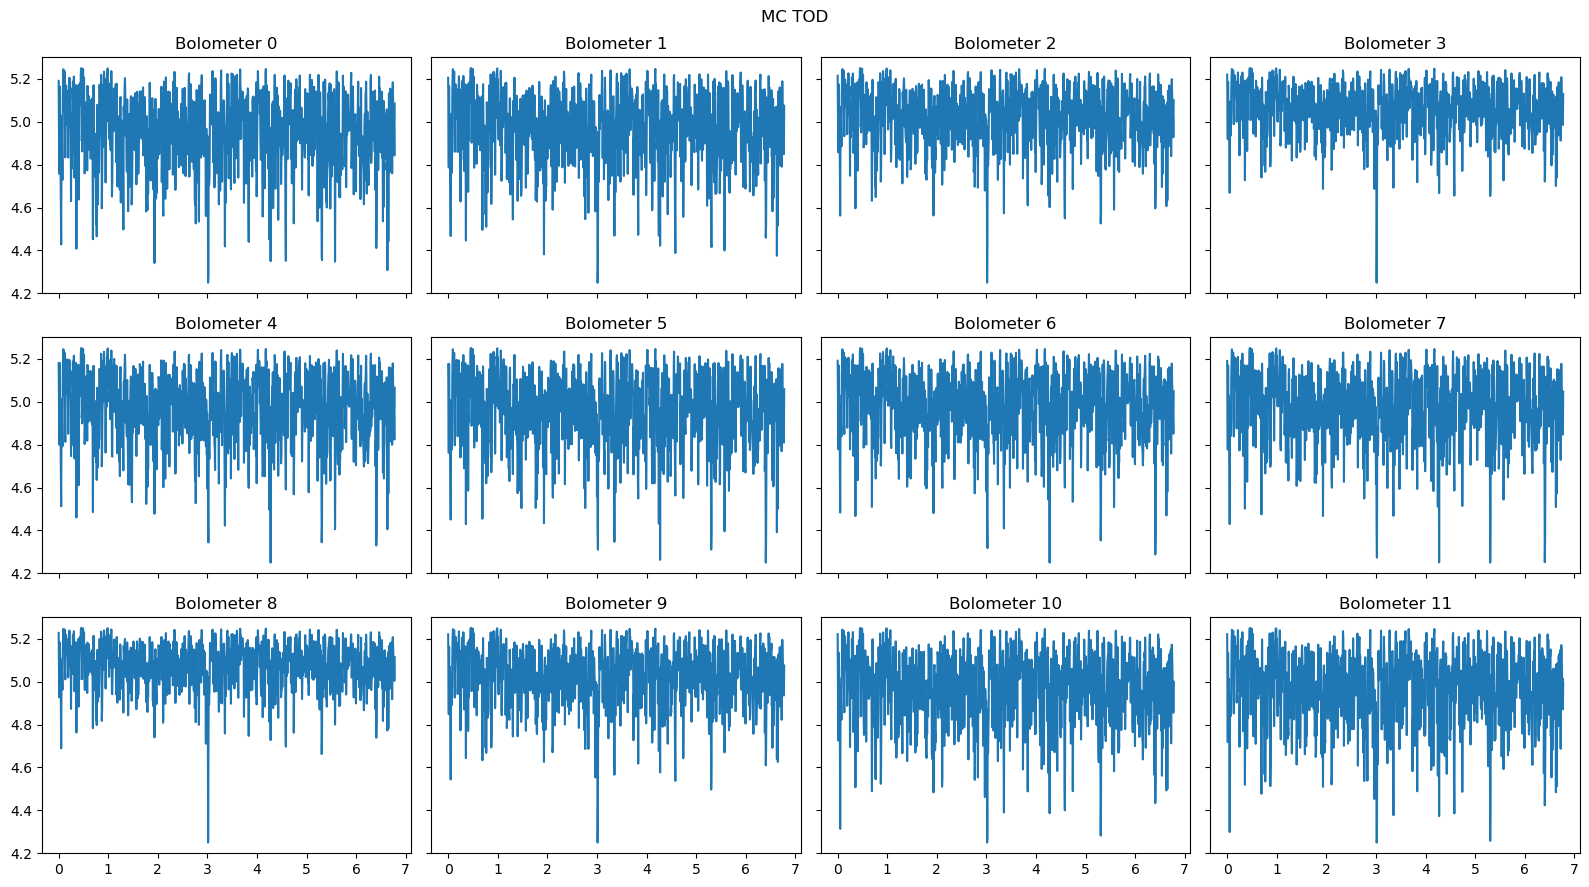

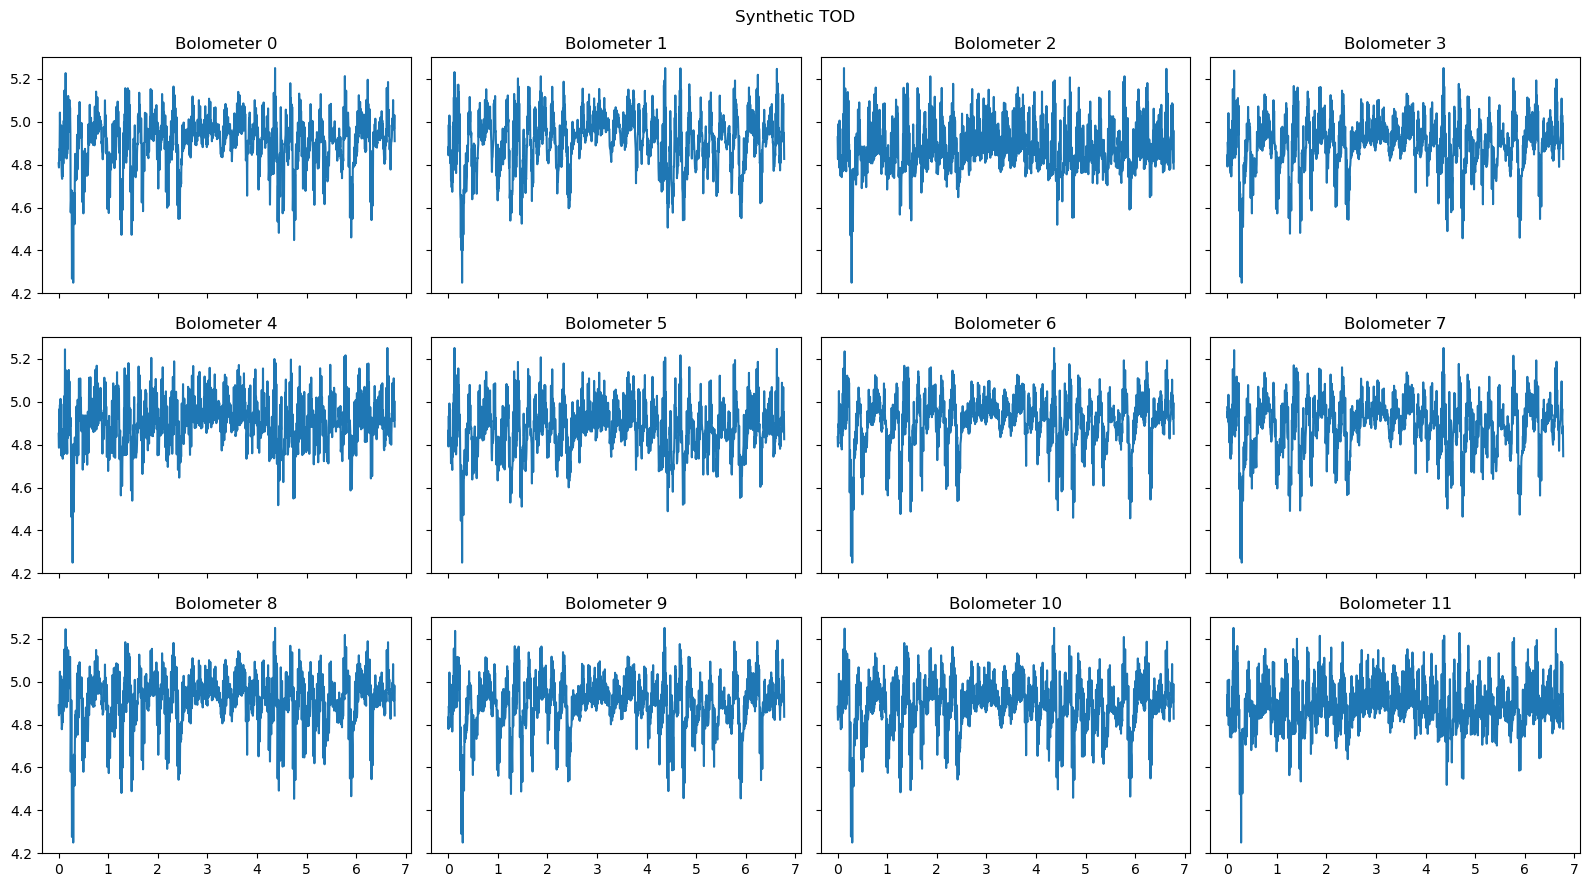

In [35]:
# Load the generated homemade TODs
data_dir = '/home/g_cavallotto/Desktop/LiteBird/NN_synthetic_TOD_code/crab/data'
data_file = 'real_TOD.npy' # homemade_TOD.npy, real_TOD.npy, gui_TOD_basic.npy, gui_TOD_digital.npy

with open(f"{data_dir}/{data_file}", 'rb') as file:
    time_steps = np.load(file)
    mins = np.load(file)
    maxs = np.load(file)
    #norm_TODs = np.load(file)
    TODs_train = np.load(file)
    #TODs_train = TODs_train[:700]
    TODs_val = np.load(file)

# Unify the training and valitation dataset
real_TODs = np.append(TODs_train, TODs_val, axis=0)

# Denormalize and concatenate the total TOD from TOD's snaps sample
real_TODs = denormalize(real_TODs, mins, maxs)
tot_real_TODs = np.concatenate(real_TODs, axis=0)
    
# Useful parameters
hit_len = int(0.07//(time_steps[0,2,0]-time_steps[0,1,0]))
bolom_number = real_TODs.shape[-1]
rows = int(np.sqrt(bolom_number))
cols = bolom_number//rows
N_TODs = real_TODs.shape[0]

# NNs input dimension
time_bins = len(time_steps[0,:,0])
inputnoise_bins = 100

# Load best model and generate synthetic TODs
# model_dir = '../models/real_gan_18'
model_dir = '../models/sam_complete_gan_32'

'''import h5py
def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.
    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()

print_structure(model_dir+'/final_generator.keras/model.weights.h5')'''

import_zip = False

if import_zip:
    import zipfile

    with zipfile.ZipFile(model_dir+'/final_generator.keras') as zip_file:
        model_h5_file = zip_file.open('model.weights.h5')
        model = load_model(model_dir+'/final_generator.keras', safe_mode=False)


gen = load_model(f'{model_dir}/final_generator.keras', safe_mode=False)
discr = load_model(f'{model_dir}/final_discriminator.keras', safe_mode=False)
trained_gan = GAN_1(gen, discr, time_bins, inputnoise_bins)

'''cross_entropy_gen = BinaryCrossentropy(from_logits=False, label_smoothing=0.1)
cross_entropy_discr = BinaryCrossentropy(from_logits=False, label_smoothing=0.)

def gen_loss(synth_preds):

    return cross_entropy_gen(np.ones(synth_preds.shape), synth_preds)

def discr_loss(real_preds, synth_preds, synth_weight):

    real_loss = cross_entropy_discr(np.ones(real_preds.shape), real_preds, sample_weight=1)
    synth_loss = cross_entropy_discr(np.zeros(synth_preds.shape), synth_preds, sample_weight=synth_weight)

    return real_loss + synth_loss

gan_pretrain.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight, tra)'''

gen.summary()
discr.summary()

# synthetic TODs generation
inputnoise = np.random.normal(size=(N_TODs, inputnoise_bins))
synth_TODs = trained_gan.generator(inputnoise)

# Denormalize and concatenate the total TOD from TOD's snaps sample
synth_TODs = denormalize(synth_TODs, mins, maxs)
tot_synth_TODs = np.concatenate(synth_TODs, axis=0)


fig1 , ax = plt.subplots(rows, cols,figsize = (16,9), sharey=True, sharex=True)
fig1.suptitle('MC TOD')

# MC TOD plots
for i in range(rows):
  for k in range(cols):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].plot(time_steps[0,:,k+i*4], real_TODs[0,:,k+i*4])
plt.tight_layout()

fig1 , ax = plt.subplots(rows, cols,figsize = (16,9), sharey=True, sharex=True)
fig1.suptitle('Synthetic TOD')

# Synthetic TOD plots
for i in range(rows):
  for k in range(cols):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].plot(time_steps[0,:,k+i*4], synth_TODs[0,:,k+i*4])
plt.tight_layout()

# Check the loaded homemade TOD
print('TODs simulated by Samantha or Guillermo have the shape: ', real_TODs.shape)
print('TODs generated with the GAN have the shape: ', synth_TODs.shape)

In [36]:
from platform import python_version
import keras
print(tf.__version__)
print(keras.__version__)
print(python_version())

import h5py
try:
    with h5py.File(model_dir + '/final_generator.keras', 'r') as f:
        print("File is a valid HDF5 file.")
except Exception as e:
    print("Error reading the file:", e)

2.13.1
2.13.1
3.11.0
Error reading the file: Unable to synchronously open file (file signature not found)


## Correlation matrix of bolometers (synthetic TODs)
- Pearson correlation matrix formula documentation: [Pennsylvania University documentation](https://online.stat.psu.edu/stat501/lesson/1/1.6).
- Pearson correlation matrix formula: $R_{ij} = \frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}$ with $C_{ij}$ the correlation matrix.

[Text(0.5, 36.72222222222221, 'Bolometers'),
 Text(70.72222222222221, 0.5, 'Bolometers')]

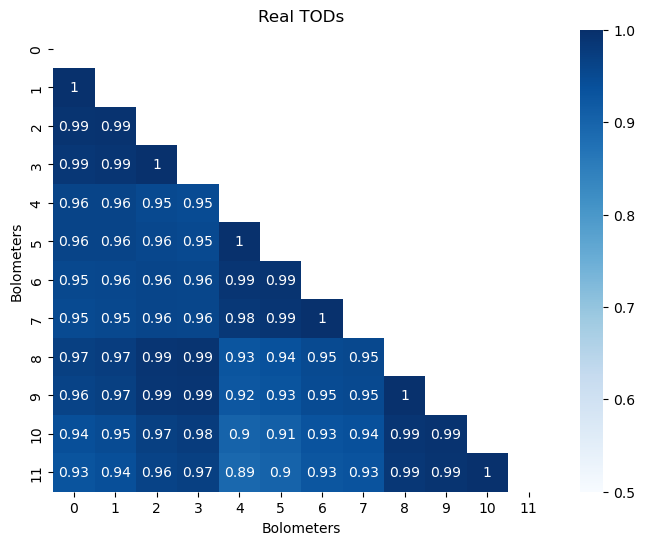

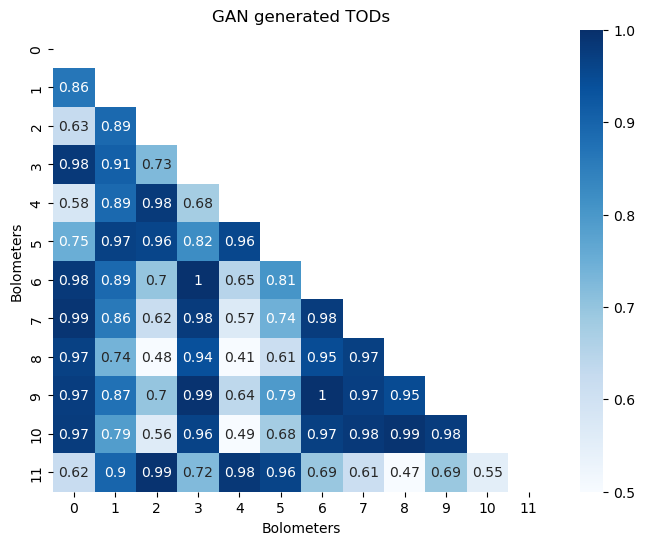

In [37]:
# Correlation matrix between bolometers
matrix_true = np.corrcoef(real_TODs[0], rowvar=False)
for i in range(1,N_TODs):
  matrix_true += np.corrcoef(real_TODs[i], rowvar=False)
matrix_true = matrix_true/(N_TODs)

matrix_synth = np.corrcoef(synth_TODs[0], rowvar=False)
for i in range(1,N_TODs):
  matrix_synth += np.corrcoef(synth_TODs[i], rowvar=False)
matrix_synth = matrix_synth/(N_TODs)

mask = np.triu(np.ones_like(matrix_synth, dtype=bool))

plt.figure(figsize = (8,6))
plt.title('Real TODs')
hm1 = sns.heatmap(matrix_true, mask = mask, annot = True, vmin = 0.5, vmax = 1, cmap='Blues')
hm1.set(xlabel='Bolometers', ylabel='Bolometers')

plt.figure(figsize = (8,6))
plt.title('GAN generated TODs')
hm2 = sns.heatmap(matrix_synth, mask = mask, annot = True, vmin = 0.5, vmax = 1, cmap='Blues')
hm2.set(xlabel='Bolometers', ylabel='Bolometers')

## Noise equivalent power (NEP)
Now the response of the TES is taken to be one, so the NEP coincide with the power spectrum.

Now are shown the NEP of 1 TOD of the sample.

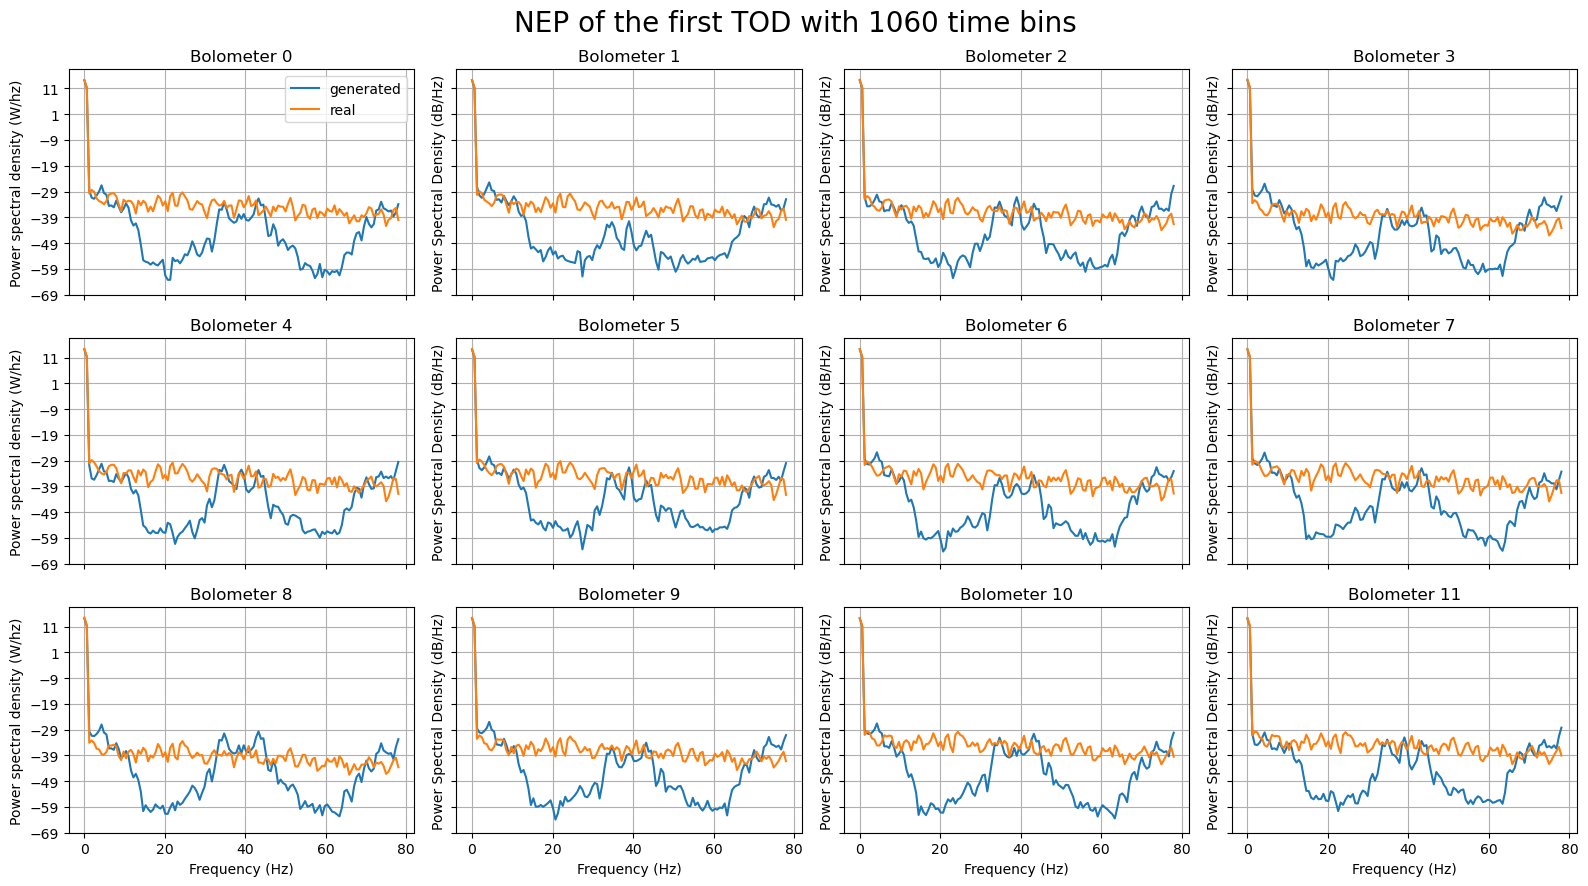

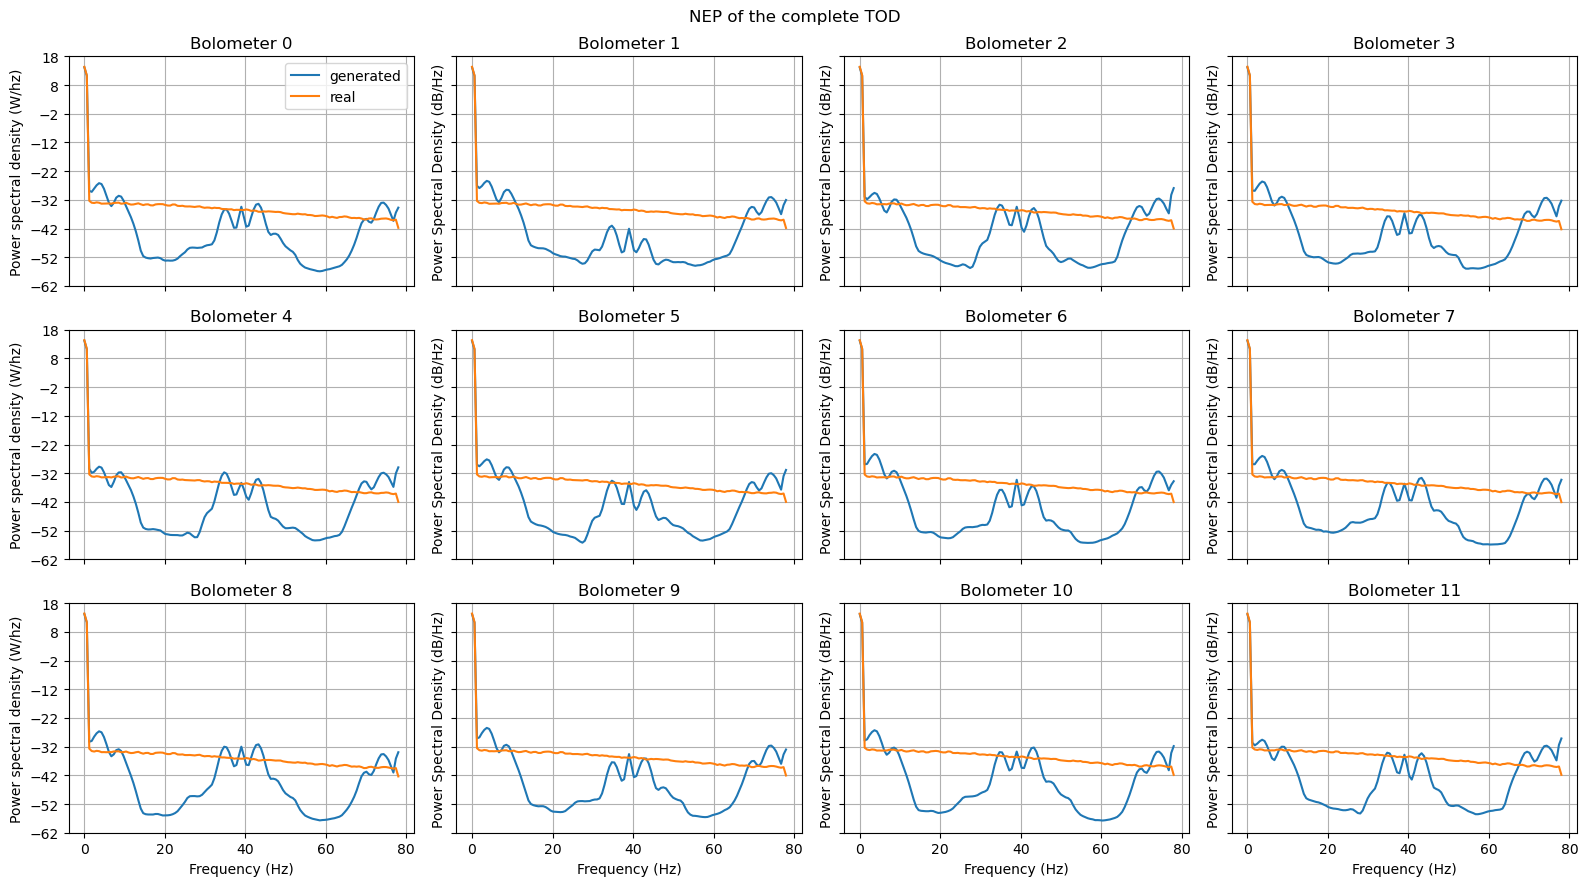

In [38]:
fig2 , ax2 = plt.subplots(rows, cols,figsize = (16,9), sharey=True, sharex=True)
fig2.suptitle('NEP of the first TOD with 1060 time bins', fontsize=20)

for i in range(rows):
  for k in range(cols):
    ax2[i,k].set_title('Bolometer ' + str(k + i*4))
    ax2[i,k].psd(synth_TODs[0, :, k+i*4], Fs = 156, label = 'generated')
    ax2[i,k].psd(real_TODs[0, :, k+i*4], Fs = 156, label = 'real')
    ax2[i,k].set(xlabel='')
    ax2[2,k].set(xlabel='Frequency (Hz)')
    # ax[i,k].set_xscale('log')
  ax2[i,0].set(ylabel='Power spectral density (W/hz)')
ax2[0,0].legend(loc='upper right')
plt.tight_layout()

fig3 , ax3 = plt.subplots(rows, cols,figsize = (16,9), sharey=True, sharex=True)
fig3.suptitle('NEP of the complete TOD')

for i in range(rows):
  for k in range(cols):
    ax3[i,k].set_title('Bolometer ' + str(k + i*4))
    ax3[i,k].psd(tot_synth_TODs[:, k+i*4], Fs = 156, label = 'generated')
    ax3[i,k].psd(tot_real_TODs[:, k+i*4], Fs = 156, label = 'real')
    ax3[i,k].set(xlabel='')
    ax3[2,k].set(xlabel='Frequency (Hz)')
    # ax[i,k].set_xscale('log')
  ax3[i,0].set(ylabel='Power spectral density (W/hz)')

ax3[0,0].legend(loc='upper right')
plt.tight_layout()

## Self correlation of the TODs
The correlation matrix is calculated between each pair of the TOD's snaps sample, computing the correlation of them bin by bin of time. Then is plotted the distribution o the correlation matrix entries for each bolometers, taken as a linearized vector of the triangle matrix half.

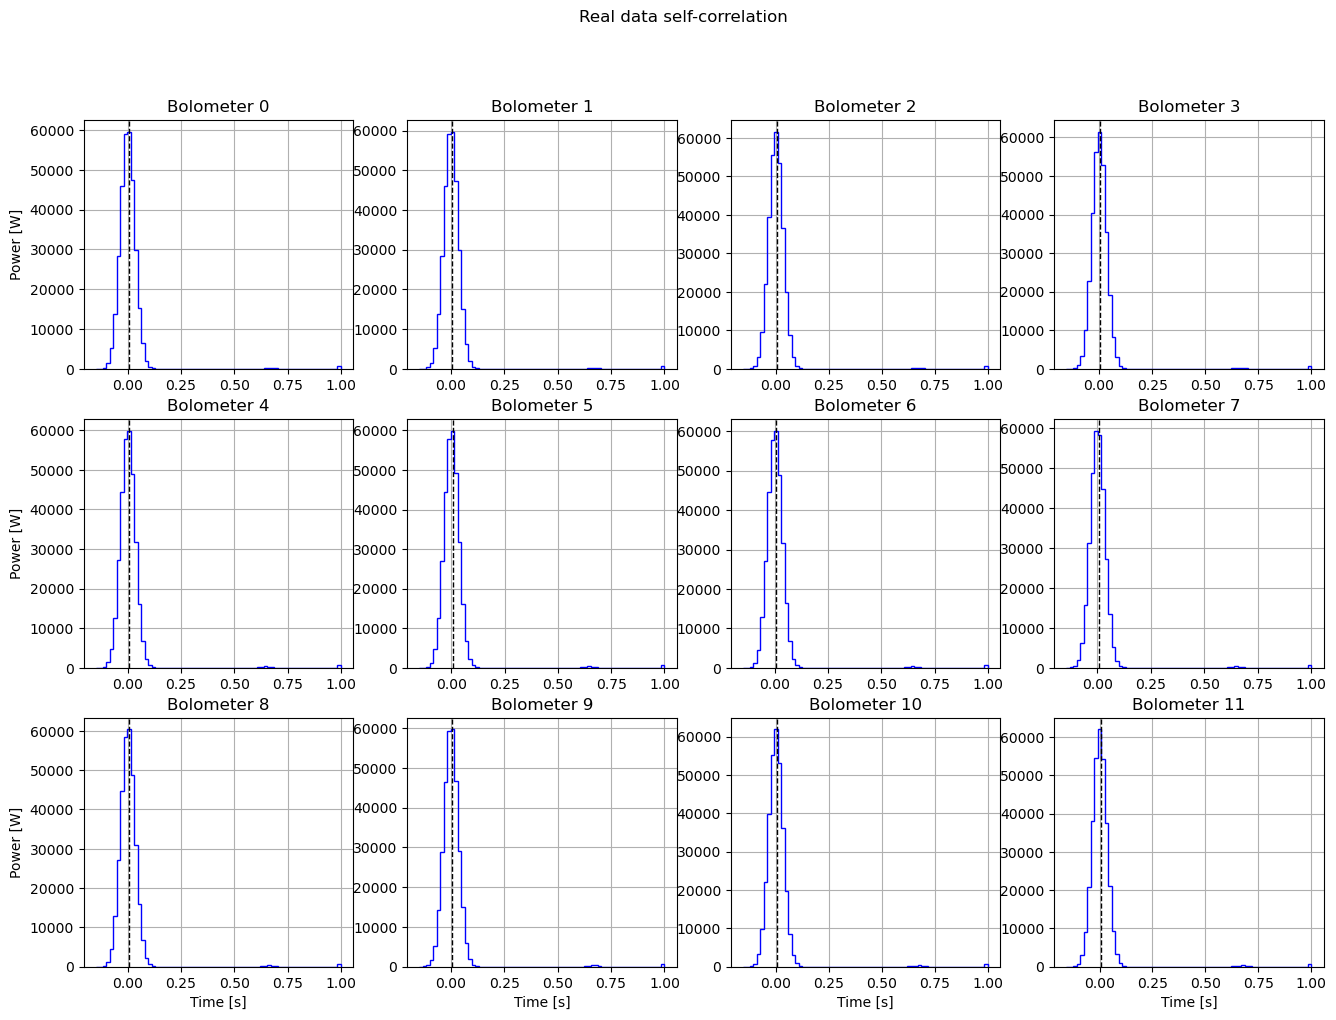

Mean real data self-correlation = 0.005595 +/- 0.072464
Mean synthetic data self-correlation =0.064154 +/- 0.147993
Mean real-synthetic data correlation =0.005595 +/- 0.072464


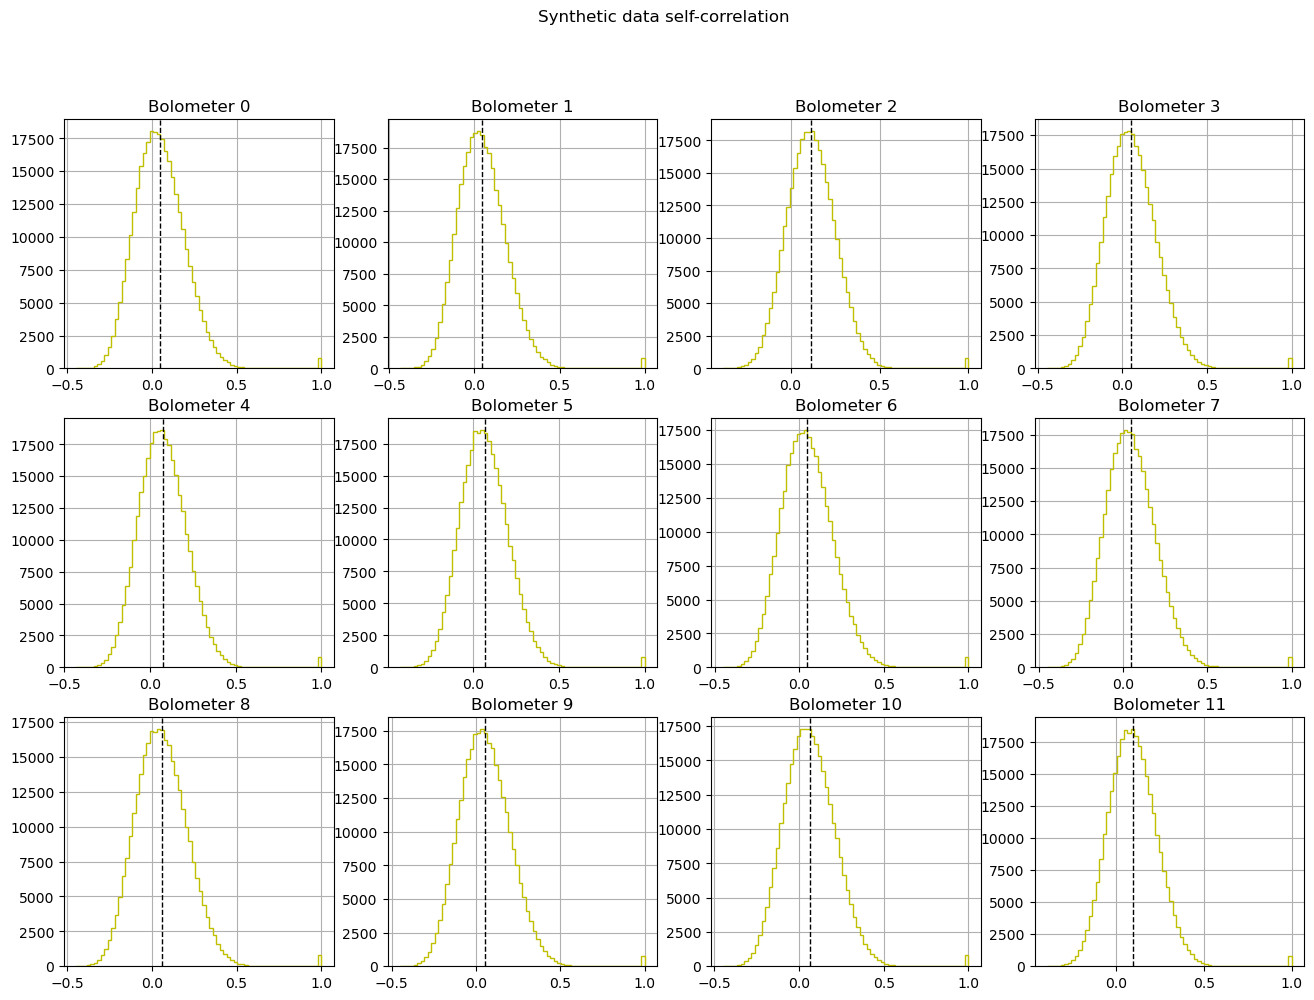

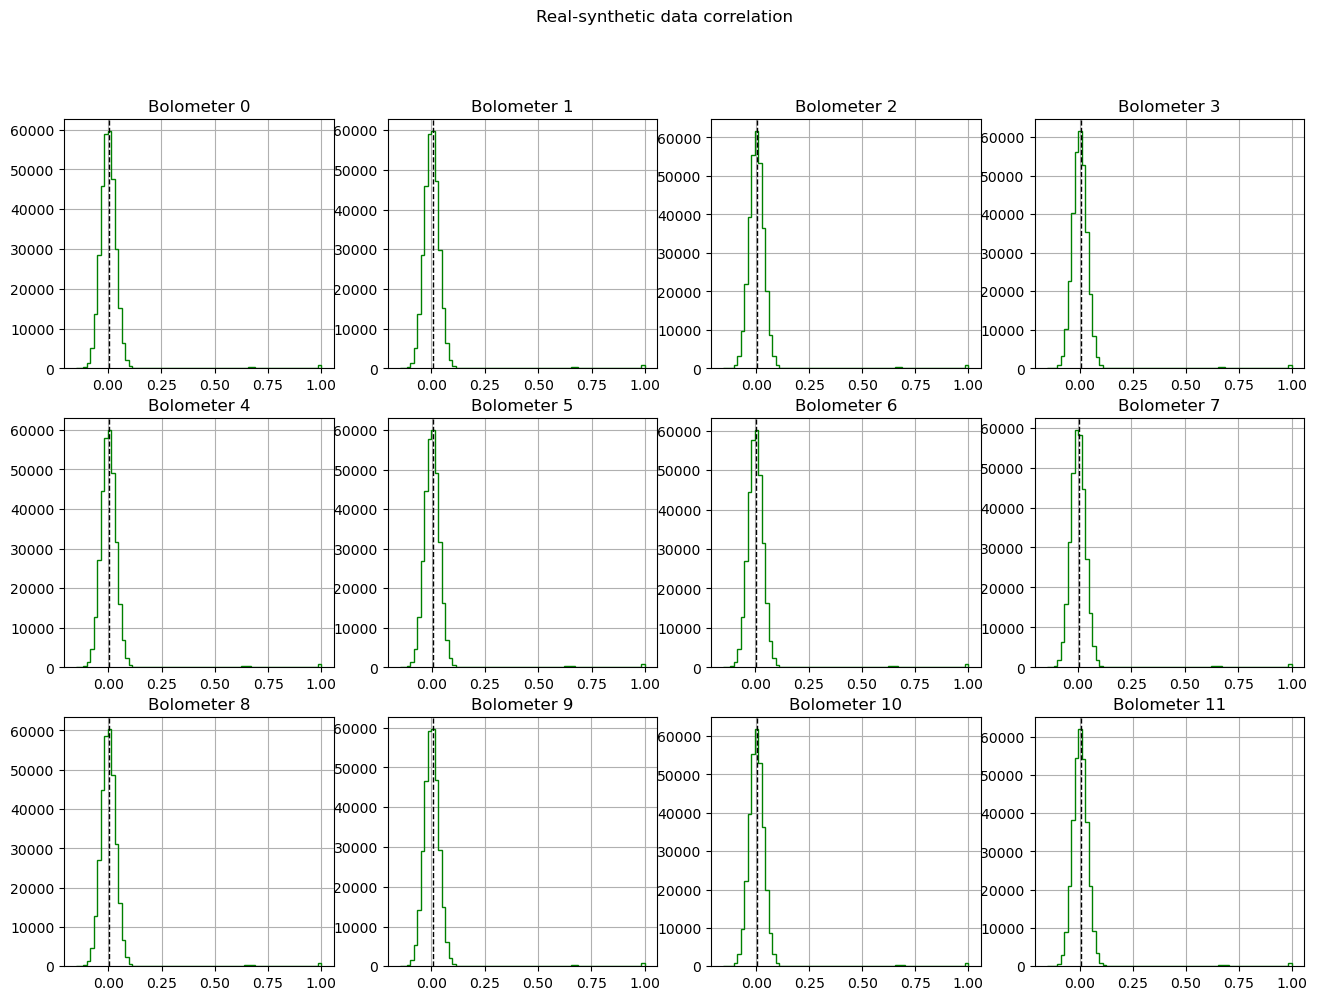

In [39]:
# Real data self-correlation
correlation_t = np.empty((bolom_number, N_TODs*(N_TODs+1)//2))
tri_mask = np.triu_indices(N_TODs)

for bol in range(bolom_number):
  correlation_t[bol] = np.corrcoef(real_TODs[:,:,bol], rowvar=True)[tri_mask]
  
fig, ax = plt.subplots(rows, cols,figsize = (16,11))
fig.suptitle('Real data self-correlation')

for i in range(rows):
  for k in range(cols):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].hist(correlation_t[k+i*4], 70, histtype = 'step', color = 'b')
    ax[i,k].axvline(correlation_t[k+i*4].mean(), color='k', linestyle='dashed', linewidth=1, label = 'mean')
    ax[i,k].grid()
plt.setp(ax[-1, :], xlabel='Time [s]')
plt.setp(ax[:, 0], ylabel='Power [W]')
plt.show()

# Synthetic data self-correlation
correlation = np.empty((bolom_number, N_TODs*(N_TODs+1)//2))

for bol in range(bolom_number):
  correlation[bol] = np.corrcoef(synth_TODs[:,:,bol], rowvar=True)[tri_mask]

fig, ax = plt.subplots(rows, cols,figsize = (16,11))
fig.suptitle('Synthetic data self-correlation')

for i in range(rows):
  for k in range(cols):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].hist(correlation[k+i*4], 70, color = 'y', histtype = 'step')
    ax[i,k].axvline(correlation[k+i*4].mean(), color='k', linestyle='dashed', linewidth=1, label = 'mean')
    ax[i,k].grid()

# Real-synthetic data correlation
correlation_tg = np.empty((bolom_number, N_TODs*(N_TODs+1)//2))

for bol in range(bolom_number):
  correlation_tg[bol] = np.corrcoef(real_TODs[:,:,bol], synth_TODs[:,:,bol], rowvar=True)[tri_mask]

fig, ax = plt.subplots(rows, cols,figsize = (16,11))
fig.suptitle('Real-synthetic data correlation')

for i in range(rows):
  for k in range(cols):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].hist(correlation_tg[k+i*4], 70, color = 'g', histtype = 'step')
    ax[i,k].axvline(correlation_tg[k+i*4].mean(), color='k', linestyle='dashed', linewidth=1, label = 'mean')
    ax[i,k].grid()

# Means and standard deviation of the the 3 correlations
mean_real = correlation_t.mean(axis=1)
std_real = correlation_t.std(axis=1)
print("Mean real data self-correlation = %f +/- %f" %(mean_real.mean(), std_real.mean()))

mean_synth = correlation.mean(axis=1)
std_synth = correlation.std(axis=1)
print("Mean synthetic data self-correlation =%f +/- %f" %(mean_synth.mean(), std_synth.mean()))

mean_tg = correlation_tg.mean(axis=1)
std_tg = correlation_tg.std(axis=1)
print("Mean real-synthetic data correlation =%f +/- %f" %(mean_tg.mean(), std_tg.mean()))

## Power distribution

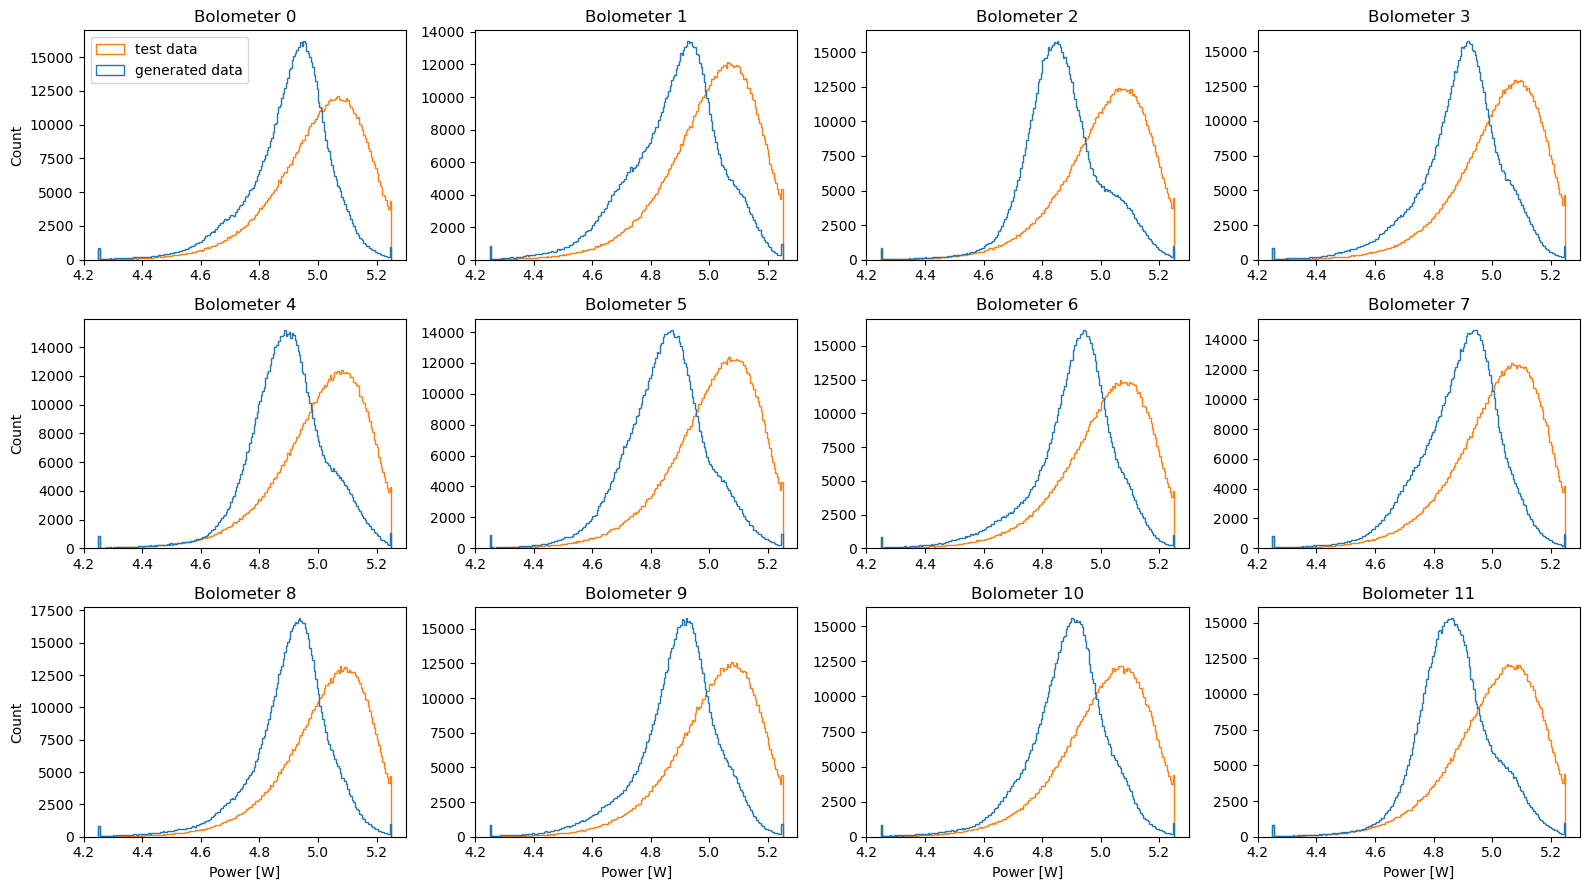

In [40]:
fig, ax = plt.subplots(rows, cols,figsize = (16,9))

plt.setp(ax[-1, :], xlabel='Power [W]')
plt.setp(ax[:, 0], ylabel='Count')

min_synth = np.min(tot_synth_TODs)

for i in range(rows):
  for k in range(cols):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].hist([tot_synth_TODs[:, k+i*4], tot_real_TODs[:, k+i*4]], 200, histtype = 'step', 
                 label=['generated data', 'test data'], range=(min(np.min(tot_synth_TODs), np.min(tot_real_TODs)), max(np.max(tot_synth_TODs), np.max(tot_real_TODs))))
ax[0,0].legend(loc='upper left')
plt.tight_layout()